<a target="_blank" href="https://colab.research.google.com/github/sriniraghunathan/reion_ksz_2pt_4pt/blob/main/simple_4pt_estimator.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Trispectrum estimator using a Quadratic estimator

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np, glob, healpy as H, os, sys
sys.path.append('modules/')
import ksz_4pt_flatsky_tools
from pylab import *

In [3]:
rcParams['figure.dpi'] = 150
rcParams['figure.facecolor'] = 'white'

In [4]:
#map specs
reso_arcmin = 0.5
reso_rad = np.radians(reso_arcmin/60.)
ny, nx = 1560, 1560
lmax = 8000
els = np.arange( lmax )
mapparams = [ny, nx, reso_arcmin, reso_arcmin]

#specs for 4-pt calculations
binsize = 50
lmax_bigK = 1000
add_circular_mask_for_big_K = True

#data or sim location
reqd_Az_str = '_Az2_'
sim_fd = 'amber/Nm1d512_box1000_ionfrac0.05-0.95_z5-40-0.2_nside8192/for_sim_comparisons_ksz/seed1/'

#filter stuff
remove_mean = True
filter_lmin_lmax_arr = [(3000., 3500.), (3500., 4000.), (4000., 4500.), (4500., 5000.)]
    
#debug options
show_plot = False #True
fsval = 14
    

In [5]:
lx, ly = ksz_4pt_flatsky_tools.get_lxly(mapparams)

#smoothing filter for visualisation
gauss_beam_fwhm_deg = 0.5
bl_for_smoothing = H.gauss_beam(np.radians(gauss_beam_fwhm_deg), 10000)
bl_2D_for_smoothing = ksz_4pt_flatsky_tools.cl_to_cl2d(np.arange(len(bl_for_smoothing)), bl_for_smoothing, mapparams)

if show_plot:
    subplot(111); imshow( np.fft.fftshift(bl_2D_for_smoothing), extent = [np.min(lx), np.max(lx), np.min(ly), np.max(ly)]); colorbar(); 
    xlabel(r'$\ell_{x}$', fontsize = fsval); #ylabel(r'$\ell_{y}$', fontsize = fsval); 
    title(r'Gaussian FWHM = %g degrees for smoothing' %(gauss_beam_fwhm_deg), fontsize = fsval-4)
    xlim(-axlim, axlim); ylim(-axlim, axlim); 
    show()
    

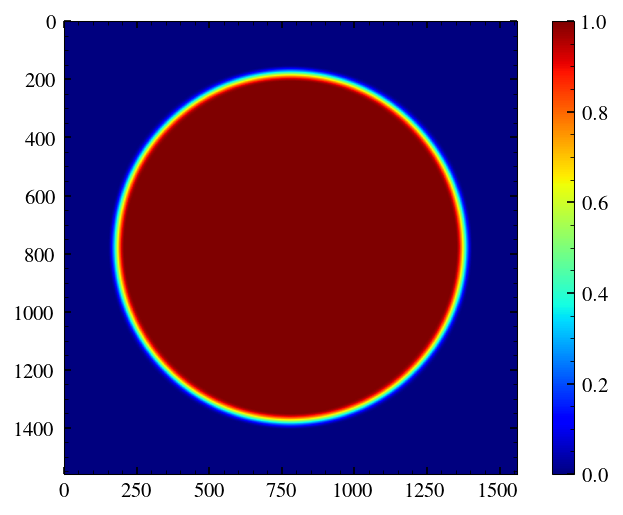

In [6]:
#mask
mask_circular = ksz_4pt_flatsky_tools.get_circular_mask(ny, nx, angres_am = reso_arcmin, circular_mask_deg = 5.)
imshow(mask_circular); colorbar(); show()

In [7]:
#get map list
maplist = sorted( glob.glob( '%s/*%s*/cmb/map_ksz_nside=8192.npy' %(sim_fd, reqd_Az_str)) )
print( '\nTotal maps = %s\n' %(len(maplist)) )#; sys.exit()

#loop over map and get the 4-pt
result_dict = {}
for mapname in maplist:

    z_re_val = float( re.findall('zre[0-9.0-9]*', mapname)[0].replace('zre', '') )
    delta_z_val = float( re.findall('Dz[0-9.0-9]*', mapname)[0].replace('Dz', '') ) 
    
    keyname = (z_re_val, delta_z_val)
    print( 'z_mid = %s, delta_z_90 = %s' %(z_re_val, delta_z_val) )
    result_dict[keyname] = {}
    ##########################################################################################
    #read map
    tmap = np.load( mapname, allow_pickle = True ) * mask_circular
    tmap_unfil = np.copy( tmap )
    ##########################################################################################
    ksz_4pt_dict = {}
    for filter_lmin_lmax in filter_lmin_lmax_arr:
        
        lmin_for_filter, lmax_for_filter = filter_lmin_lmax
        print('\t(lmin, lmax) = (%g, %g)' %(lmin_for_filter, lmax_for_filter))

        
        #get filter
        wl_1d, wl_2D = ksz_4pt_flatsky_tools.get_filter(els, lmin_for_filter = lmin_for_filter, lmax_for_filter = lmax_for_filter, mapparams = mapparams)
        '''
        if (lmax_for_filter, lmax_for_filter) != (lmax_for_filter2, lmax_for_filter2):
            wl2_1d, wl2_2D = ksz_4pt_flatsky_tools.get_filter(els, lmin_for_filter = lmin_for_filter2, lmax_for_filter = lmax_for_filter2, mapparams = mapparams)
        '''

        if show_plot:
            clf()        
            plot(els, wl_1d); xlabel(r'Multipole $\ell$', fontsize = fsval); ylabel(r'Filter $w_{\ell}$', fontsize = fsval); 
            title(r'Filter $\ell \in [%g, %g]$' %(lmin_for_filter, lmax_for_filter), fontsize = fsval)
            show()

            clf()
            axlim = 6000.
            subplot(111); imshow( np.fft.fftshift(wl_2D), extent = [np.min(lx), np.max(lx), np.min(ly), np.max(ly)]); colorbar(); 
            xlabel(r'$\ell_{x}$', fontsize = fsval); ylabel(r'$\ell_{y}$', fontsize = fsval); 
            title(r'Filter $\ell \in [%g, %g]$' %(lmin_for_filter, lmax_for_filter), fontsize = fsval-4)
            xlim(-axlim, axlim); ylim(-axlim, axlim); 
            

        ##########################################################################################
        #filter maps
        tmap1 = np.fft.ifft2( np.fft.fft2( tmap ) * wl_2D ).real
        if (0):##(lmax_for_filter, lmax_for_filter) != (lmax_for_filter2, lmax_for_filter2):
            tmap2 = np.fft.ifft2( np.fft.fft2( tmap ) * w2_2D ).real
        else:
            tmap2 = np.copy( tmap1 )
            
        ##imshow(tmap1); colorbar(); show(); sys.exit()

        #get power spectrum
        el_2pt, cl_m1_unfiltered = ksz_4pt_flatsky_tools.map2cl(mapparams, tmap_unfil, binsize = binsize, maxbin = lmax, mask = mask_circular)
        el_2pt, cl_m1 = ksz_4pt_flatsky_tools.map2cl(mapparams, tmap1, binsize = binsize, maxbin = lmax, mask = mask_circular)

        #get kbar
        fbar = ksz_4pt_flatsky_tools.get_kbar(els, wl_1d)
        tmp_cl_m1_ip = np.interp(els, el_2pt, cl_m1)
        kbar = ksz_4pt_flatsky_tools.get_kbar(els, wl_1d, tmpcls_signal = tmp_cl_m1_ip, filter_only = False)
        if (1):
            tmplinds = np.where( (el_2pt>=lmin_for_filter) & ((el_2pt<=lmax_for_filter)))
            dl_fac = el_2pt * (el_2pt+1)/2/np.pi
            dl_m1 = cl_m1 * dl_fac
            dl_m1_mean = np.mean( dl_m1[tmplinds] )
            print( '\t\t', 'Dl mean = %.2f uk^2; fbar = %.2f; kbar = %.2f uk^2; Dl * fbar = %.2f uk^2' %(dl_m1_mean, fbar, kbar, dl_m1_mean*fbar) );
            ##sys.exit()
                
        if show_plot:


            '''
            if (lmax_for_filter, lmax_for_filter) != (lmax_for_filter2, lmax_for_filter2): #20231109
                el_, cl_m2 = ksz_4pt_flatsky_tools.map2cl(mapparams, tmap2, binsize = binsize, maxbin = lmax, mask = mask_circular)
            '''

            clf()
            ax = subplot(111)#, yscale='log')
            dl_fac = el_ * (el_+1)/2/np.pi
            plot(el_, dl_fac * cl_m1_unfiltered, color = 'gray')
            plot(el_, dl_fac * cl_m1, color = 'black', lw = 4.)
            '''
            if (lmax_for_filter, lmax_for_filter) != (lmax_for_filter2, lmax_for_filter2): #20231109
                plot(el_, dl_fac * cl_m2, color = 'red')
            '''
            xlim(0., 6000.); ylim(0., 5.)
            show(); #sys.exit()

            clf()
            x1,x2, y1, y2 = 500, 1000, 500,1000
            vmin, vmax = -20., 20.
            subplot(121); imshow( tmap_unfil[x1:x2, y1:y2], vmin = vmin, vmax =vmax ); colorbar();  title(r'Unfiltered'); #unfiltered
            subplot(122); imshow( tmap1[x1:x2, y1:y2], vmin = vmin, vmax = vmax ); colorbar();  title(r'Filtered'); #filtered with w1_2D
            show()
            if (lmax_for_filter, lmax_for_filter) != (lmax_for_filter2, lmax_for_filter2): #20231109
                subplot(121); imshow( tmap_unfil[x1:x2, y1:y2], vmin = vmin, vmax = vmax ); colorbar(); title(r'Unfiltered');  #unfiltered
                subplot(122); imshow( tmap2[x1:x2, y1:y2]); colorbar(); title(r'Filtered');  #filtered with w2_2D
                show()
            #sys.exit()                
        ##########################################################################################

        ##########################################################################################
        #get bigK and power spectrum
        big_k_m1, mask_mod, el_4pt, cl_big_k_m1 = ksz_4pt_flatsky_tools.get_4pt_flatsky(tmap1, smap2 = tmap2, mask = mask_circular, angres_am = reso_arcmin)#, add_new_mask_for_big_K = add_new_mask_for_big_K)        

        #smoothed with Gaussian beam
        big_k_m1_smoothed = np.fft.ifft2( np.fft.fft2(big_k_m1) * bl_2D_for_smoothing).real
        
        ksz_4pt_dict[filter_lmin_lmax] = [big_k_m1_smoothed, el_4pt, cl_big_k_m1, el_2pt, cl_m1, kbar, fbar]

        if show_plot:
            subplot(121); imshow( big_k_m1, vmin = 0, vmax =100.); colorbar(); 
            subplot(122); imshow( big_k_m1_smoothed, vmin = -0.5, vmax = 2.5); colorbar(); 
            show()
        
            clf()
            dlfac_str = 'elsq'
            #dlfac_str = 'el'
            if dlfac_str == 'elsq':
                yscaleval = 'log'
                ylabval = r'$L(L+1)\ C_{L}^{KK}/2\pi$ [$\mu$K$^{4}$]'
                ymin, ymax = 1e-4, 1.
                dl_fac = el_ * (el_+1)/2/np.pi
            elif dlfac_str == 'el':
                yscaleval = None
                ymin, ymax = -1e-3, 1e-3
                ylabval = r'$L C_{L}^{KK}$ [$\mu$K$^{4}$]'
                dl_fac = el_

            clf()
            ax = subplot(111, yscale = 'log', xscale='log')
            plot(el_, dl_fac * cl_big_k_m1, color = 'black')
            xlim(50., 1000.); ylim(ymin, ymax)
            xlabel(r'Multipole $L$', fontsize = fsval)
            ylabel(ylabval, fontsize = fsval)
            axvspan(100., 400., color = 'orangered', alpha = 0.5)
            show(); sys.exit()     
        ##########################################################################################
    result_dict[keyname] = ksz_4pt_dict
#sys.exit()


Total maps = 5

z_mid = 7.74086, delta_z_90 = 4.36283
	(lmin, lmax) = (3000, 3500)
		 Dl mean = 1.86 uk^2; fbar = 0.15; kbar = 0.28 uk^2; Dl * fbar = 0.29 uk^2
	(lmin, lmax) = (3500, 4000)
		 Dl mean = 1.88 uk^2; fbar = 0.13; kbar = 0.24 uk^2; Dl * fbar = 0.25 uk^2
	(lmin, lmax) = (4000, 4500)
		 Dl mean = 1.81 uk^2; fbar = 0.12; kbar = 0.21 uk^2; Dl * fbar = 0.21 uk^2
	(lmin, lmax) = (4500, 5000)
		 Dl mean = 1.82 uk^2; fbar = 0.11; kbar = 0.19 uk^2; Dl * fbar = 0.19 uk^2
z_mid = 8.09399, delta_z_90 = 6.07768
	(lmin, lmax) = (3000, 3500)
		 Dl mean = 2.58 uk^2; fbar = 0.15; kbar = 0.39 uk^2; Dl * fbar = 0.40 uk^2
	(lmin, lmax) = (3500, 4000)
		 Dl mean = 2.51 uk^2; fbar = 0.13; kbar = 0.33 uk^2; Dl * fbar = 0.33 uk^2
	(lmin, lmax) = (4000, 4500)
		 Dl mean = 2.40 uk^2; fbar = 0.12; kbar = 0.28 uk^2; Dl * fbar = 0.28 uk^2
	(lmin, lmax) = (4500, 5000)
		 Dl mean = 2.41 uk^2; fbar = 0.11; kbar = 0.25 uk^2; Dl * fbar = 0.26 uk^2
z_mid = 8.46139, delta_z_90 = 4.32245
	(lmin, lmax) = (3000

(7.74086, 4.36283)
(8.09399, 6.07768)
(8.46139, 4.32245)
(8.46139, 4.97214)
(9.44614, 4.94372)


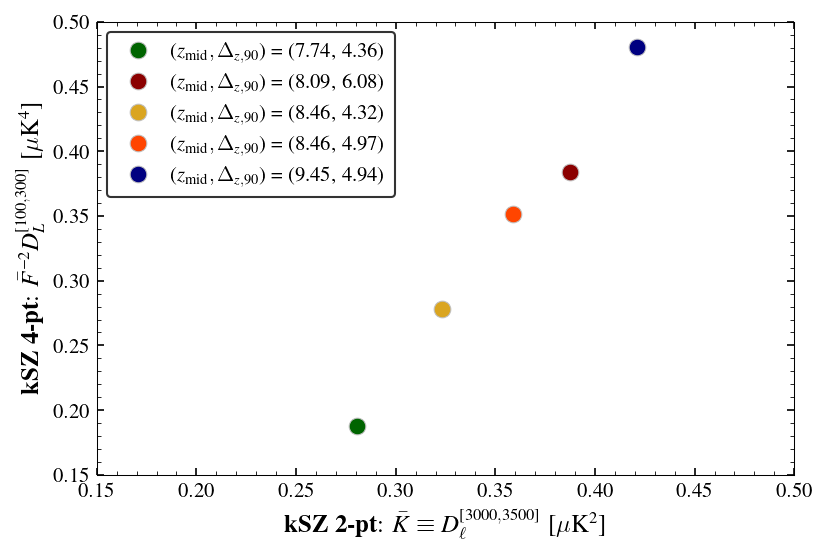

In [9]:
#4-pt vs 2-pt plots
reqd_filter_lmin, reqd_filter_lmax = 3000., 3500.
reqd_filter_lmin_lmax = (reqd_filter_lmin, reqd_filter_lmax)
reqd_Lmin, reqd_Lmax = 100, 300

xmin, xmax = 0.15, 0.5
ymin, ymax = 0.15, 0.5 #None, None
clf()
msval = 8.
fsval = 12
ax = subplot(111)
color_arr = ['navy', 'darkgreen', 'goldenrod', 'orangered', 'darkred']
#color_arr = [ cm.Set1(int(d)) for d in np.linspace( 0, 8, len(result_dict) ) ]
np.random.shuffle(color_arr)
for kcntr, keyname in enumerate( sorted( result_dict ) ):

    #zre, deltaz
    z_re_val, delta_z_val = keyname
    labval = r'$(z_{\rm mid}, \Delta_{z, 90})$ = (%.2f, %.2f)' %(z_re_val, delta_z_val)
    print(keyname)

    #get results for some (lmin, lmax)
    big_k_m1_smoothed, el_4pt, cl_big_k_m1, el_2pt, cl_ksz, kbar, fbar = result_dict[keyname][reqd_filter_lmin_lmax]
    dl_fac = el_4pt * (el_4pt+1)/2/np.pi
    dl_big_k_m1_prime = dl_fac * cl_big_k_m1 / fbar**2.
    Linds = np.where( (el_4pt>=reqd_Lmin) & (el_4pt<=reqd_Lmax) )[0]
    dl_big_k_m1_prime_mean = np.mean(dl_big_k_m1_prime[Linds])

    #plot 4-pt/fbar**2 vs kbar
    plot(kbar, dl_big_k_m1_prime_mean, marker = 'o', ls = 'None', ms = msval, mec = 'silver', mew = 0.5, color = color_arr[kcntr], label = labval)

xlim(xmin, xmax); ylim(ymin, ymax)
xlabel(r'{\bf kSZ 2-pt}: $\bar{K} \equiv D_{\ell}^{[%g, %g]}$ [$\mu$K${^2}$]' %(reqd_filter_lmin, reqd_filter_lmax), fontsize = fsval)
ylabel(r'{\bf kSZ 4-pt}: $\bar{F}^{-2} D_{L}^{[%g, %g]}$ [$\mu$K${^4}$]' %(reqd_Lmin, reqd_Lmax), fontsize = fsval)
legend(loc = 2, fontsize = fsval - 2, ncol = 1, columnspacing = 0.5, handletextpad = 0.5, numpoints = 1)
show();

(7.74086, 4.36283)


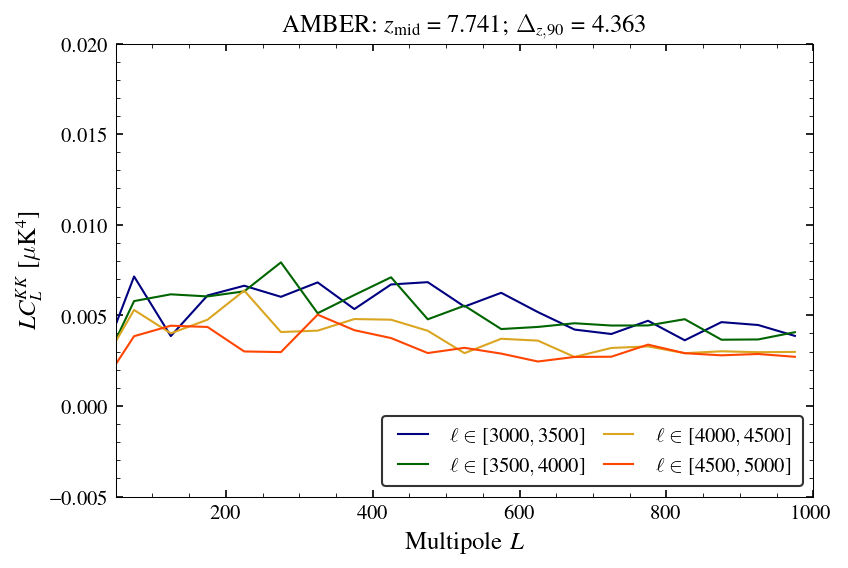

(8.09399, 6.07768)


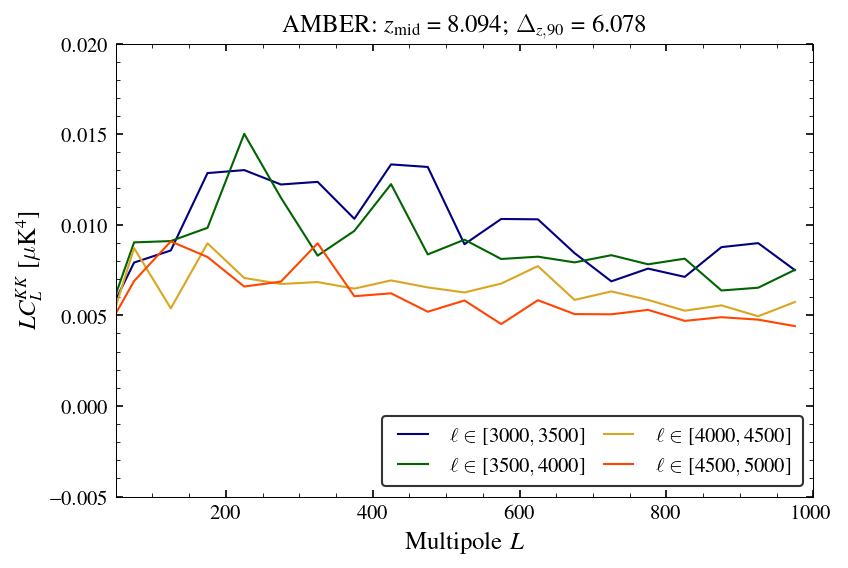

(8.46139, 4.32245)


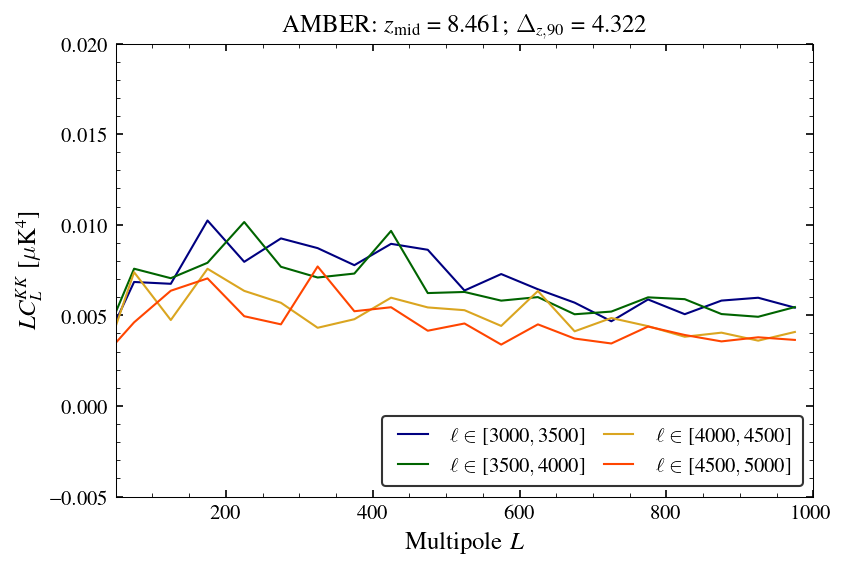

(8.46139, 4.97214)


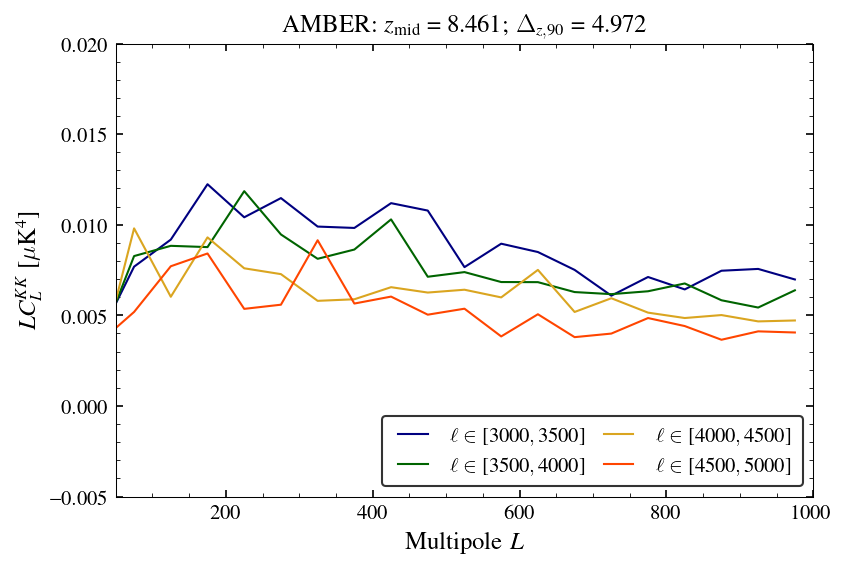

(9.44614, 4.94372)


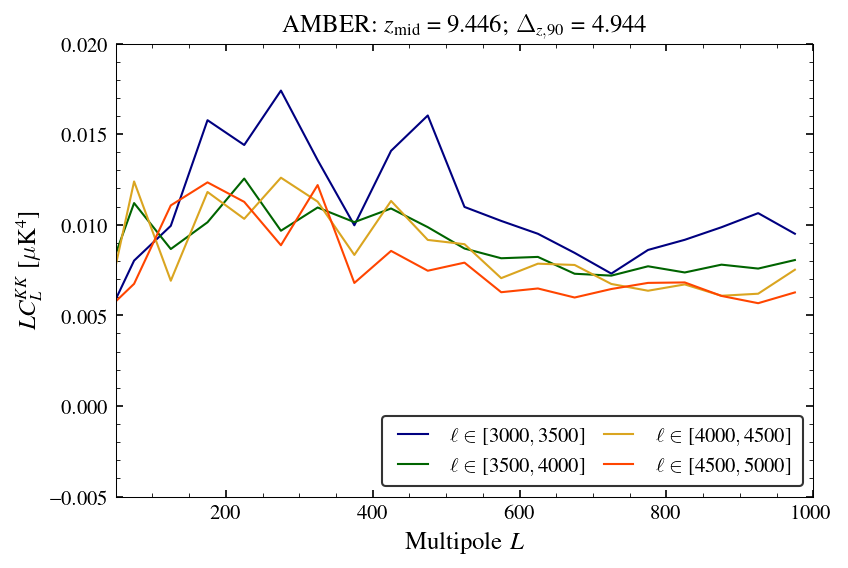

In [10]:
#4-pt plots

color_arr = ['navy', 'darkgreen', 'goldenrod', 'orangered', 'darkred']
#dlfac_str = 'elsq'
dlfac_str = 'el'
if dlfac_str == 'elsq':
    scaleval = 'log'
    ylabval = r'$L(L+1)\ C_{L}^{KK}/2\pi$ [$\mu$K$^{4}$]'
    ymin, ymax = 1e-4, 1.
elif dlfac_str == 'el':
    scaleval = None
    #ymin, ymax = -1e-3, 1e-3
    ymin, ymax = -0.5e-2, 2e-2
    ylabval = r'$L C_{L}^{KK}$ [$\mu$K$^{4}$]'

for keyname in result_dict:
    z_re_val, delta_z_val = keyname
    print(keyname)
    ksz_4pt_dict = result_dict[keyname]
    title_str = r'AMBER: $z_{\rm mid}$ = %.3f; $\Delta_{z, 90}$ = %.3f' %(z_re_val, delta_z_val)


    clf()
    ax = subplot(111, yscale = scaleval, xscale= scaleval)
    for filter_lmin_lmax_cntr, filter_lmin_lmax in enumerate( sorted(ksz_4pt_dict) ):
        ##print(filter_lmin_lmax_cntr)
        big_k_m1_smoothed, el_4pt, cl_big_k_m1, el_2pt, cl_ksz, kbar, fbar = ksz_4pt_dict[filter_lmin_lmax]
        if dlfac_str == 'elsq':
            dl_fac = el_4pt * (el_4pt+1)/2/np.pi
        elif dlfac_str == 'el':
            dl_fac = el_4pt
        plot(el_4pt, dl_fac * cl_big_k_m1 / fbar**2., color = color_arr[filter_lmin_lmax_cntr], label = r'$\ell \in [%g, %g]$' %(filter_lmin_lmax[0], filter_lmin_lmax[1]))
        #plot(el_4pt, dl_fac * cl_big_k_m1, color = color_arr[filter_lmin_lmax_cntr], ls = '-.')

    xlim(50., 1000.); ylim(ymin, ymax)
    xlabel(r'Multipole $L$', fontsize = fsval)
    ylabel(ylabval, fontsize = fsval)
    legend(loc = 4, fontsize = fsval - 2, ncol = 2, columnspacing = 0.5)
    #axvspan(100., 400., color = 'orangered', alpha = 0.5)
    title(title_str, fontsize = fsval)
    show();     